In [3]:
from pathlib import Path
import yaml
import obspy
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent

with open(PROJECT_ROOT / "config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

DATA_ROOT = Path(cfg["paths"]["data_root"])
LABELED_DATA = Path(cfg["paths"]["labeled_data"])
UNLABELED_DATA = Path(cfg["paths"]["unlabeled_data"])

FIGURES_DIR = PROJECT_ROOT / cfg["paths"]["figures_output"]
TABLES_DIR = PROJECT_ROOT / cfg["paths"]["tables_output"]
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"

FIGURES_DIR.mkdir(exist_ok=True)
TABLES_DIR.mkdir(exist_ok=True)

print("PROJECT_ROOT :", PROJECT_ROOT)
print("FIGURES_DIR  :", FIGURES_DIR.resolve())
print("TABLES_DIR   :", TABLES_DIR.resolve())



PROJECT_ROOT : c:\Users\nicol\Documents\AAST_PJ\AAST_PJ
FIGURES_DIR  : C:\Users\nicol\Documents\AAST_PJ\AAST_PJ\figures
TABLES_DIR   : C:\Users\nicol\Documents\AAST_PJ\AAST_PJ\tables


In [ ]:

stats = defaultdict(list)


if not LABELED_DATA.exists():
    print(f"ERROR: La ruta {LABELED_DATA} no existe")
    exit()


for event_dir in LABELED_DATA.iterdir():
    if not event_dir.is_dir():
        continue
    
    event_type = event_dir.name
    print(f"Procesando: {event_type}")
    
    
    mseed_files = [f for f in event_dir.iterdir() if f.is_file()]
    
    print(f"  Archivos encontrados: {len(mseed_files)}")
    
    if len(mseed_files) == 0:
        print(f"  ⚠ No se encontraron archivos en {event_dir}")
        continue
    
    for mseed_file in mseed_files:
        try:
            
            st = obspy.read(str(mseed_file))
            
            
            for tr in st:
                stats['tipo'].append(event_type)
                stats['archivo'].append(mseed_file.name)
                stats['duracion_s'].append(float(tr.stats.endtime - tr.stats.starttime))
                stats['freq_muestreo_hz'].append(tr.stats.sampling_rate)
                stats['num_muestras'].append(tr.stats.npts)
                stats['estacion'].append(tr.stats.station)
                stats['canal'].append(tr.stats.channel)
                stats['delta_s'].append(tr.stats.delta)
                
        except Exception as e:
            print(f"  ✗ Error en {mseed_file.name}: {e}")


df = pd.DataFrame(stats)

Procesando: LP
  Archivos encontrados: 577
Procesando: TC
  Archivos encontrados: 2198
Procesando: TR
  Archivos encontrados: 471
Procesando: VT
  Archivos encontrados: 2686
Procesando: HY
  Archivos encontrados: 213


In [ ]:
print("\n" + "="*70)
print("RESUMEN POR TIPO DE EVENTO")
print("="*70)

summary = df.groupby('tipo').agg({
    'duracion_s': ['mean', 'std', 'min', 'max', 'count'],
    'freq_muestreo_hz': ['mean', 'min', 'max'],
    'num_muestras': ['mean', 'min', 'max']
}).round(2)
summary


✓ Total de registros procesados: 6145

RESUMEN POR TIPO DE EVENTO


duracion_s                           freq_muestreo_hz                \
           mean    std   min    max count             mean    min    max   
tipo                                                                       
HY        57.20  35.31  9.99  265.0   213           208.45  200.0  500.0   
LP        82.27  63.51  8.99  600.0   577           255.63  200.0  500.0   
TC        78.53  56.24  8.99  670.0  2198           222.11  200.0  500.0   
TR        46.19  33.78  8.99  216.0   471           206.37  200.0  500.0   
VT        19.60  12.32  5.00  189.0  2686           201.56  200.0  500.0   

     num_muestras                
             mean   min     max  
tipo                             
HY       11775.59  2000   53000  
LP       20182.15  1800  120000  
TC       17709.55  1800  134000  
TR        9566.88  1800  101500  
VT        3949.44  1000   37800

In [ ]:

print("\n" + "="*70)
print("ANÁLISIS DE FRECUENCIAS DE MUESTREO")
print("="*70)


unique_freqs = df['freq_muestreo_hz'].unique()
print(f"\nFrecuencias únicas encontradas: {sorted(unique_freqs)} Hz")
print(f"Total de frecuencias diferentes: {len(unique_freqs)}")


print("\nDistribución general de frecuencias:")
freq_dist = df['freq_muestreo_hz'].value_counts().sort_index()
for freq, count in freq_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {freq:6.1f} Hz: {count:4d} eventos ({percentage:5.1f}%)")


most_common_freq = df['freq_muestreo_hz'].mode().values[0]
print(f"\n✓ Frecuencia más común: {most_common_freq} Hz")
print(f"  ({(df['freq_muestreo_hz'] == most_common_freq).sum()} eventos, {(df['freq_muestreo_hz'] == most_common_freq).sum()/len(df)*100:.1f}%)")


print("\n" + "-"*70)
print("RECOMENDACIÓN PARA RESAMPLING")
print("-"*70)
if len(unique_freqs) > 1:
    print(f"⚠ Detectadas {len(unique_freqs)} frecuencias diferentes")
    print(f"✓ Recomendación: Aplicar resampling a {most_common_freq} Hz")
    print(f"\nEventos que necesitarían resampling:")
    for freq in sorted(unique_freqs):
        if freq != most_common_freq:
            count = (df['freq_muestreo_hz'] == freq).sum()
            print(f"  {freq} Hz → {most_common_freq} Hz: {count} eventos")
else:
    print(f"✓ Todos los eventos tienen la misma frecuencia: {most_common_freq} Hz")
    print("  No es necesario hacer resampling")



ANÁLISIS DE FRECUENCIAS DE MUESTREO

Frecuencias únicas encontradas: [np.float64(200.0), np.float64(500.0)] Hz
Total de frecuencias diferentes: 2

Distribución general de frecuencias:
   200.0 Hz: 5846 eventos ( 95.1%)
   500.0 Hz:  299 eventos (  4.9%)

✓ Frecuencia más común: 200.0 Hz
  (5846 eventos, 95.1%)

----------------------------------------------------------------------
RECOMENDACIÓN PARA RESAMPLING
----------------------------------------------------------------------
⚠ Detectadas 2 frecuencias diferentes
✓ Recomendación: Aplicar resampling a 200.0 Hz

Eventos que necesitarían resampling:
  500.0 Hz → 200.0 Hz: 299 eventos


In [ ]:

print("\n" + "="*70)
print("DETALLES POR TIPO")
print("="*70)

for event_type in df['tipo'].unique():
    subset = df[df['tipo'] == event_type]
    
    print(f"\n{event_type.upper()}")
    print(f"  Cantidad de eventos: {len(subset)}")
    print(f"  Duración promedio: {subset['duracion_s'].mean():.2f} ± {subset['duracion_s'].std():.2f} s")
    print(f"  Duración [min, max]: [{subset['duracion_s'].min():.2f}, {subset['duracion_s'].max():.2f}] s")
    
    
    type_freqs = subset['freq_muestreo_hz'].unique()
    if len(type_freqs) == 1:
        print(f"  Frecuencia de muestreo: {type_freqs[0]:.0f} Hz (uniforme)")
    else:
        print(f"  Frecuencias de muestreo: {sorted(type_freqs)} Hz (mixtas)")
        for freq in sorted(type_freqs):
            count = (subset['freq_muestreo_hz'] == freq).sum()
            print(f"    - {freq:.0f} Hz: {count} eventos")
    
    print(f"  Canales únicos: {', '.join(subset['canal'].unique())}")
    print(f"  Estaciones únicas: {', '.join(subset['estacion'].unique())}")



DETALLES POR TIPO

LP
  Cantidad de eventos: 577
  Duración promedio: 82.27 ± 63.51 s
  Duración [min, max]: [8.99, 600.00] s
  Frecuencias de muestreo: [np.float64(200.0), np.float64(500.0)] Hz (mixtas)
    - 200 Hz: 470 eventos
    - 500 Hz: 107 eventos
  Canales únicos: 001
  Estaciones únicas: LC05, LC01, LC06, LC08, LC03, LC04, B2DA, LC07, LC10, LC09

TC
  Cantidad de eventos: 2198
  Duración promedio: 78.53 ± 56.24 s
  Duración [min, max]: [8.99, 670.00] s
  Frecuencias de muestreo: [np.float64(200.0), np.float64(500.0)] Hz (mixtas)
    - 200 Hz: 2036 eventos
    - 500 Hz: 162 eventos
  Canales únicos: 001
  Estaciones únicas: LC05, LC04, LC07, LC09, LC08, LC03, LC01, LC06, LC10, B2DA

TR
  Cantidad de eventos: 471
  Duración promedio: 46.19 ± 33.78 s
  Duración [min, max]: [8.99, 216.00] s
  Frecuencias de muestreo: [np.float64(200.0), np.float64(500.0)] Hz (mixtas)
    - 200 Hz: 461 eventos
    - 500 Hz: 10 eventos
  Canales únicos: 001
  Estaciones únicas: LC04, LC05, LC03, L


✓ Gráficos guardados en: C:\Users\nicol\Documents\AAST_PJ\AAST_PJ\figures\analisis_eventos_volcanicos.png
✓ Datos guardados en:
  - C:\Users\nicol\Documents\AAST_PJ\AAST_PJ\tables\detalle_eventos.csv
  - C:\Users\nicol\Documents\AAST_PJ\AAST_PJ\tables\resumen_eventos.csv


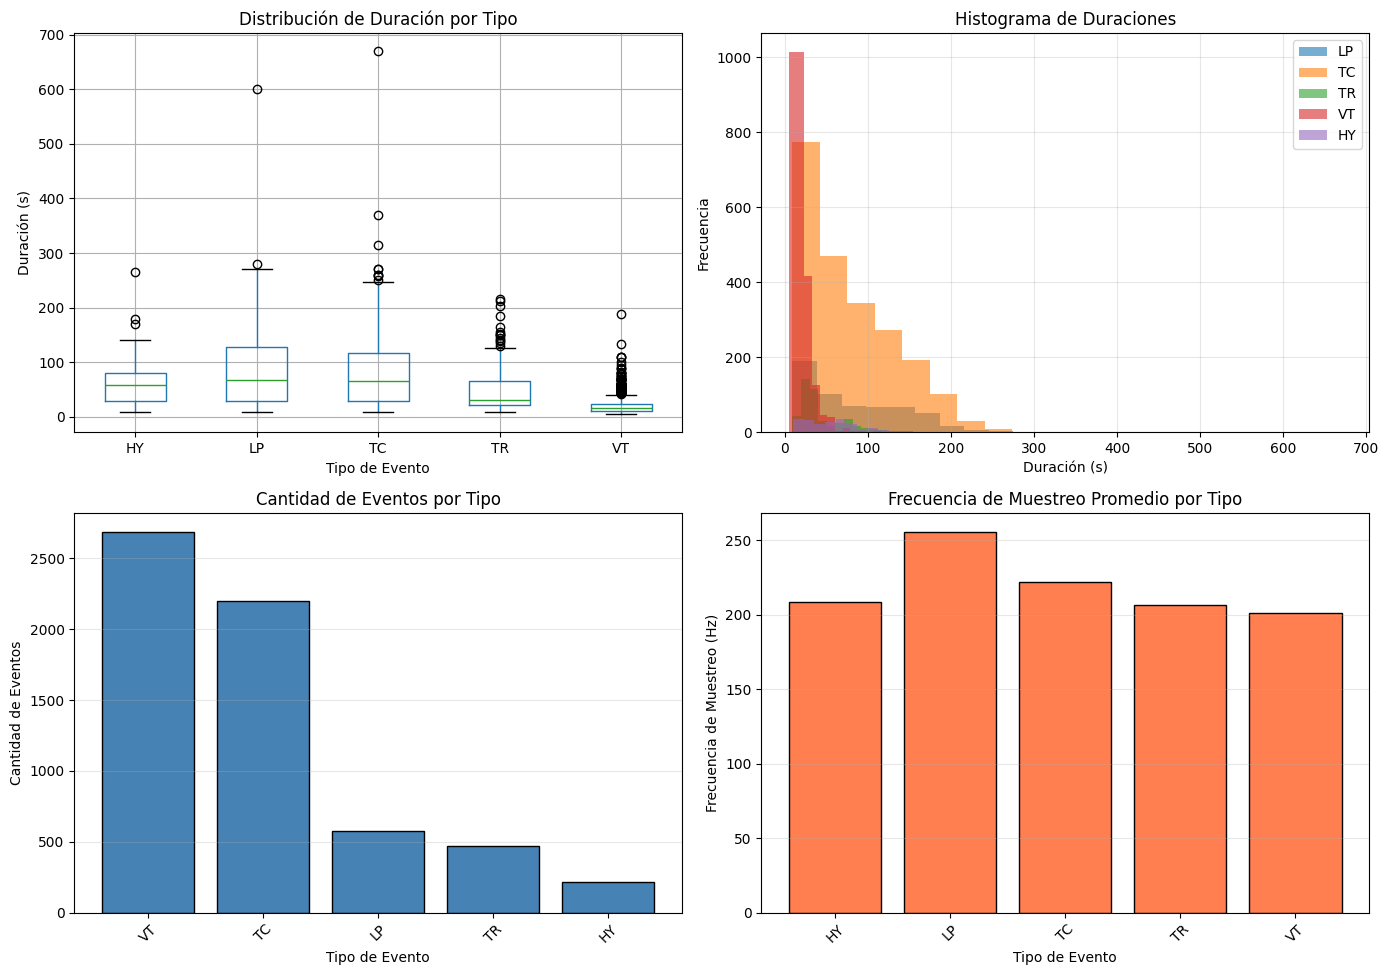

In [ ]:


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Eventos Volcánicos por Tipo', fontsize=16, fontweight='bold')


df.boxplot(column='duracion_s', by='tipo', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Duración por Tipo')
axes[0, 0].set_xlabel('Tipo de Evento')
axes[0, 0].set_ylabel('Duración (s)')
axes[0, 0].get_figure().suptitle('')


for event_type in df['tipo'].unique():
    subset = df[df['tipo'] == event_type]
    axes[0, 1].hist(subset['duracion_s'], alpha=0.6, label=event_type, bins=20)
axes[0, 1].set_xlabel('Duración (s)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Histograma de Duraciones')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)


event_counts = df['tipo'].value_counts()
axes[1, 0].bar(event_counts.index, event_counts.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Tipo de Evento')
axes[1, 0].set_ylabel('Cantidad de Eventos')
axes[1, 0].set_title('Cantidad de Eventos por Tipo')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')


freq_by_type = df.groupby('tipo')['freq_muestreo_hz'].mean()
axes[1, 1].bar(freq_by_type.index, freq_by_type.values, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Tipo de Evento')
axes[1, 1].set_ylabel('Frecuencia de Muestreo (Hz)')
axes[1, 1].set_title('Frecuencia de Muestreo Promedio por Tipo')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

fig_path = FIGURES_DIR / "analisis_eventos_volcanicos.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")


print(f"\n✓ Gráficos guardados en: {fig_path.resolve()}")


detalle_path = TABLES_DIR / "detalle_eventos.csv"
resumen_path = TABLES_DIR / "resumen_eventos.csv"

df.to_csv(detalle_path, index=False)
summary.to_csv(resumen_path)

print(f"✓ Datos guardados en:")
print(f"  - {detalle_path.resolve()}")
print(f"  - {resumen_path.resolve()}")

plt.show()
